In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import cv2
import datetime

## Goal : Building a custom CNN model that predicts and insect's class 

### GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
print("gpus", gpus)

gpus [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Settings

In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64 
NB_CLASSES = 6
EPOCHS = 20

VALIDATION_SPLIT = 0.15

np.random.seed(1)

labels = {
    "coleoptera" : 0, 
    "diptera" : 1, 
    "hemiptera" : 2, 
    "hymenoptera" : 3, 
    "lepidoptera" : 4, 
    "odonata" : 5
}

# path for the insect dataset
DATASET_PATH = "/home/valentin/Desktop/deep_learning/practice_learn/datasets/ArTaxOr" 

ALL_IMAGES = [cls+"/"+image_path for cls in labels for image_path in os.listdir(os.path.join(DATASET_PATH,cls.capitalize()))]
print(f"found a total of {len(ALL_IMAGES)} images ")

np.random.shuffle(ALL_IMAGES)


found a total of 12964 images 


### Splitting the paths between two sets

In [4]:
train, test = train_test_split(ALL_IMAGES, test_size=VALIDATION_SPLIT)
print(f"length of the training set : {len(train)}")
print(f"length of the testing set : {len(test)}")

length of the training set : 11019
length of the testing set : 1945


### Dataset

In [5]:
import random
import json

class InsectDataset(tf.keras.utils.Sequence): 
    
    def __init__(self, x_set, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE): 
        """
            WARNING : SHUFFLE THE DATASET BEFORE ! 
            x_set : path of the image
        """
        self.x_set = x_set 
        self.image_size = image_size 
        self.batch_size = batch_size 
        self.y_set = [path.split("/")[0] for path in x_set]
        
    def __len__(self):
        return len(self.x_set) // self.batch_size
        
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_x = self.x_set[i:i+self.batch_size] 
        batch_y = self.y_set[i:i+self.batch_size] 
        # get numpy array for each batch_x element 
        # arrays
        images = []
        targets = []
        for i,path in enumerate(batch_x): 
            image_path = os.path.join(DATASET_PATH, path.capitalize())
            # normalizing : [0-1]
            array = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            if array is not None: 
                array = cv2.cvtColor(array, cv2.COLOR_BGR2RGB)
                array = cv2.resize(array, self.image_size)
                images.append(array/255.0) 

                # one hot encoding 
                target = batch_y[i]
                one_hot = tf.one_hot(labels[target], depth=len(labels)) 
                targets.append(one_hot)
        return np.array(images), np.array(targets)
            
            

### Visualization

In [6]:
def visualize_batch(X,y): 
    plt.figure(figsize=(15, 10))
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        title = get_title(y[i])
        plt.title(title)
        plt.axis("off")
        
        
def get_title(label): 
    """
        label is one hot encoded
    """
    target = np.argmax(label) 
    return list(labels.keys())[target]

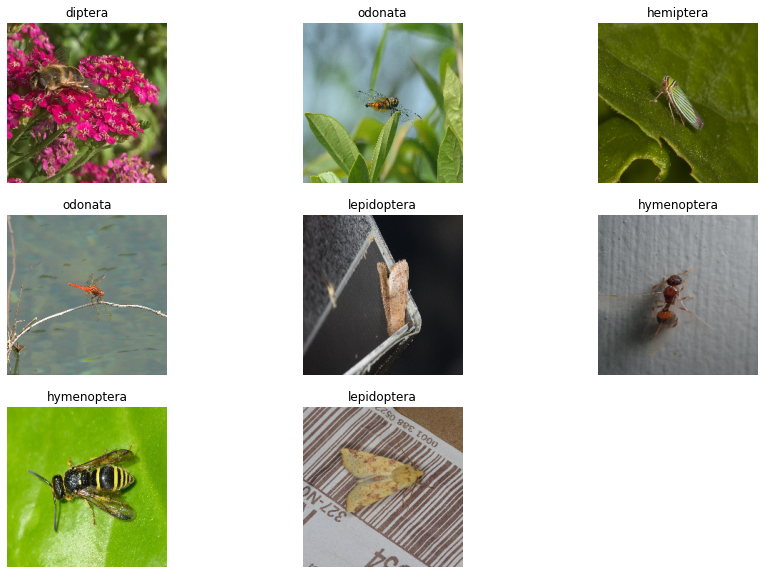

In [7]:
dataset = InsectDataset(ALL_IMAGES)
X,y = dataset[0] 
visualize_batch(X,y)

In [8]:
train_gen = InsectDataset(train) 
test_gen = InsectDataset(test)

print(train_gen) 
print(test_gen)

In [9]:
def tiny_vgg(): 
    
    """
        A VGG16 approach
        
        TODO : better init
    """
    
    inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,)) 
    x = inputs
    for i in range(2):
        x = tf.keras.layers.Conv2D(28, 3, padding="same")(x)
        x = tf.keras.activations.relu(x)
        
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.activations.relu(x)
    
    for i in range(4):
        x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
        x = tf.keras.activations.relu(x)
    
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.activations.relu(x)
    
    for i in range(2):
        x = tf.keras.layers.Conv2D(128, 3, padding="same")(x)
        x = tf.keras.activations.relu(x)
        
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.activations.relu(x)
    
    # flatten 
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(len(labels))(x)
    outputs = tf.keras.activations.sigmoid(x)
    
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [10]:
vgg = tiny_vgg()
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 28)      784       
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 224, 224, 28)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 28)      7084      
_________________________________________________________________
tf.nn.relu_1 (TFOpLambda)    (None, 224, 224, 28)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 28)      0         
_________________________________________________________________
tf.nn.relu_2 (TFOpLambda)    (None, 112, 112, 28)      0     

In [11]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


callbacks = [
    tensorboard_callback, 
    tf.keras.callbacks.ModelCheckpoint("tiny_vgg_insect_clf.h5", save_best_only=True)
]

In [12]:
vgg.compile(
    optimizer=tf.keras.optimizers.SGD(), 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=["accuracy"]
)

In [ ]:
%tensorboard --logdir logs/fit

In [13]:
vgg.fit(
    train_gen, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=test_gen,
    callbacks=callbacks
)

Epoch 1/20
172/172 [==============================] - 961s 6s/step - loss: 1.7899 - accuracy: 0.1843 - val_loss: 1.7889 - val_accuracy: 0.1818
Epoch 2/20
172/172 [==============================] - 917s 5s/step - loss: 1.7856 - accuracy: 0.1871 - val_loss: 1.7811 - val_accuracy: 0.1870
Epoch 3/20
172/172 [==============================] - 895s 5s/step - loss: 1.7714 - accuracy: 0.2126 - val_loss: 1.7618 - val_accuracy: 0.2370
Epoch 4/20
172/172 [==============================] - 906s 5s/step - loss: 1.7543 - accuracy: 0.2413 - val_loss: 1.7487 - val_accuracy: 0.2344
Epoch 5/20
172/172 [==============================] - ETA: 0s - loss: 1.7436 - accuracy: 0.2599

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt

